I'm going to try to learn a CNN that reproduces the signal processing of a microscope. I'm going to train on some images that I believe are "bags of GFP" -- Colleen's IDRs and Zelda C-terminal fragments. I measure the concentration of these via the standard candles, that means I can make a reasonable simulation of the "true image" — just n fluors randomly distributed within the mask. I can make a lot of sims for each real image. The CNN needs to output an n X n X n image, the loss function is some simple measure of pixel intensity difference (I think mean difference per non-zero pixel? Obvi can try multiple things).

Workflow:

1. Make an initial training set (simulations of real c-terminal nuclei with 80 nM free)
2. Design a 1 conv layer network to test (just get it to ouput proper size and test loss function)

In [237]:
from importlib import reload
import flymovie as fm
import cnn_models.siamese_cnn as cn
import cnn_models.evaluate_models as ev
from flymovie.simnuc import Sim
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import string
import tensorflow as tf
import pickle
from importlib import reload
from sklearn.manifold import TSNE
import scipy.ndimage as ndi
import skimage as ski

from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras import Model
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [238]:
imfolder = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/blackbox/reals/'
outfolder = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/blackbox/sims/'
imfile = 'zld-cterm_20220321-zld-cterm-gfp-em1-01_0_1.pkl'

In [239]:
im = fm.load_pickle(os.path.join(imfolder, imfile))
mask = ndi.morphology.binary_erosion(np.where(im > 0, 1, 0), structure=np.ones((1,7,7)))

In [244]:
for imfile in os.listdir(imfolder):
    if imfile[0] == '.':
        continue
    im = fm.load_pickle(os.path.join(imfolder, imfile))
    mask = ndi.morphology.binary_erosion(np.where(im > 0, 1, 0), structure=np.ones((1,7,7)))

In [246]:
for imfile in os.listdir(imfolder):
    if imfile[0] == '.':
        continue
    im = fm.load_pickle(os.path.join(imfolder, imfile))
    mask = ndi.morphology.binary_erosion(np.where(im > 0, 1, 0), structure=np.ones((1,7,7)))

    for _ in range(1):
        leader = ''.join(random.choice(string.ascii_letters) for i in range(3)) + '_'
        sim = Sim(mask, 250,85)
        nmolecules = round(sim.conc_to_nmolecules(80))
        sim.add_n_objects(nmolecules, 1, 1, 1)
        filename = os.path.join(outfolder, leader + imfile)
        fm.save_pickle(sim.im, filename)

In [58]:
reals_folder = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/blackbox/reals/'
sims_folder = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/blackbox/sims/'
batch_size = 32
image_shape = (34,100,100)

In [59]:
#tf.data.Dataset.from_tensor_slices(anchor_files)

sim_files1 = os.listdir(sims_folder)
sim_files2 = []
real_files = []
for f in sim_files1:
    if f[0] == '.':
        continue

    splits = f.split('_')
    real_file = '_'.join(splits[1:])
    sim_files2.append(os.path.join(sims_folder, f))
    real_files.append(os.path.join(reals_folder, real_file))


In [74]:
def preprocess_images(im_sim, im_real):
    [sim,] = tf.py_function(cn.preprocess_image,[im_sim,],[tf.float32,])
    [real,] = tf.py_function(cn.preprocess_image,[im_real,],[tf.float32,])
    #sim = tf.squeeze(sim)
    #real = tf.squeeze(real)
    return sim, real


In [75]:

sim_ds = tf.data.Dataset.from_tensor_slices((sim_files2, real_files))
#real_ds = tf.data.Dataset.from_tensor_slices(real_files)

sim_ds = sim_ds.map(preprocess_images, num_parallel_calls=tf.data.AUTOTUNE)
#real_ds = real_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

sim_ds = sim_ds.batch(batch_size, drop_remainder=False)
#real_ds = real_ds.batch(batch_size, drop_remainder=False)

In [99]:
num_elem = np.product(image_shape)
img_input = layers.Input(shape=image_shape + (1,)) # Channels last.
#x = layers.ZeroPadding3D(padding=(5, 10, 10), name='psf_pad')(img_input)
x = layers.Conv3D(1, (10,20,20),
        strides=(1, 1, 1),
        padding='same',
        kernel_initializer='he_normal',
        name='psf')(img_input)

#x = layers.ZeroPadding3D(padding=(3, 3, 3), name='conv1_pad')(x)
"""
x = layers.Conv3D(64, (3,3,3),
        strides=(1, 1, 1),
        padding='same',
        kernel_initializer='he_normal',
        name='conv1')(x)
"""

#x = layers.Flatten()(x)
#x = layers.Dense(num_elem, activation='linear')(x)
output = tf.math.reduce_sum(x, axis=-1)
#x = tf.keras.backend.sum(x, axis=-1)
#x = layers.Reshape(tuple([64]) + image_shape)(x)
model = Model(img_input, output, name="Embedding")

In [81]:
sim_ds = tf.data.Dataset.from_tensor_slices((sim_files2, real_files))

sim_ds = sim_ds.map(preprocess_images, num_parallel_calls=tf.data.AUTOTUNE)

sim_ds = sim_ds.batch(batch_size, drop_remainder=False)


In [100]:
#dataset = tf.data.Dataset.zip((sim_ds, real_ds))
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tf.keras.losses.mean_squared_error)
model.fit(sim_ds, epochs=3)

Epoch 1/3
1/1 [==============================] - 27s 27s/step - loss: 0.0267
Epoch 2/3
1/1 [==============================] - 29s 29s/step - loss: 0.0172
Epoch 3/3
1/1 [==============================] - 29s 29s/step - loss: 0.0114


In [145]:
model.fit(sim_ds, epochs=3)

Epoch 1/3
1/1 [==============================] - 28s 28s/step - loss: 0.0091
Epoch 2/3
1/1 [==============================] - 30s 30s/step - loss: 0.0094
Epoch 3/3
1/1 [==============================] - 30s 30s/step - loss: 0.0111


In [85]:
sims = []
for i in sim_ds:
    sims.append(i)

In [101]:
t = model(np.expand_dims(sims[0][0][1], axis=0))

fm.viewer(t.numpy() * 1000, 5)

interactive(children=(Dropdown(description='Color', index=10, options=('Reds', 'plasma', 'gray', 'magma', 'inf…

In [121]:
l = model.layers[1]

In [146]:
w = l.get_weights()[0]
w = np.squeeze(w)
fm.viewer(w * 1_000, 5)

interactive(children=(Dropdown(description='Color', index=10, options=('Reds', 'plasma', 'gray', 'magma', 'inf…

In [195]:
def norm(x):
    #x_nz = x[x > 0]
    x_nz = x
    #return x
    return (x - np.min(x_nz)) / (np.max(x_nz) - np.min(x_nz))

real = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/blackbox/reals/zld-cterm_20220321-zld-cterm-gfp-em1-01_0_1.pkl')
real = norm(real)
mask = ndi.morphology.binary_erosion(np.where(real > 0, 1, 0), structure=np.ones((1,7,7)))

In [165]:
sim = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/blackbox/sims/GUB_zld-cterm_20220321-zld-cterm-gfp-em1-01_0_1.pkl')

In [180]:
kernel = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/PSFs/psf_20220210_21x25x25pixels_100x50x50voxel.pkl')
print(kernel.shape)
kernel = ndi.zoom(kernel, (100/250, 50/85, 50/85))
print(kernel.shape)
kernel = kernel / np.sum(kernel)

(21, 25, 25)
(8, 15, 15)


In [235]:
cv = ndi.convolve(sim, kernel)
cv = norm(cv)
n = np.random.normal(0, 0.4, size=cv.shape)
n = np.where(mask > 0, n, 0)
cv = cv + n
cv = norm(cv)

In [236]:
fm.viewer([cv * 1000, real * 1000],5)

interactive(children=(Dropdown(description='Color', index=10, options=('Reds', 'plasma', 'gray', 'magma', 'inf…

In [170]:
fm.viewer((cv - real) * 1000, 5)

interactive(children=(Dropdown(description='Color', index=10, options=('Reds', 'plasma', 'gray', 'magma', 'inf…

In [197]:
res = real - cv
res = res[mask > 0]

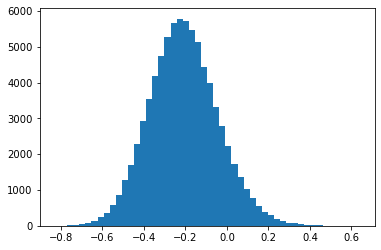

In [198]:
plt.hist(res, bins=50);

In [208]:
import scipy
x = scipy.stats.norm(loc=-0.2, scale=0.15)
#plt.plot(x)


In [220]:
n = np.random.normal(0, 0.15, size=(34,100,100))
n = n - np.min(n)
n = np.where(mask > 0, n, 0)


In [221]:
fm.viewer(n * 1000, 5)

interactive(children=(Dropdown(description='Color', index=10, options=('Reds', 'plasma', 'gray', 'magma', 'inf…

interactive(children=(Dropdown(description='Color', index=10, options=('Reds', 'plasma', 'gray', 'magma', 'inf…

In [247]:
tf.keras.models.load_model('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/blackbox/model')